Explore the performance of isolation forest for unsupervised dataset retrival on HTRU2

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import sys
sys.path.append('src')

from sklearn.ensemble import IsolationForest

In [2]:
from JACS_utils.ARFF import ARFF

ar = ARFF()
X,Y, _ = ar.read('datasets/htru2_period+Lyon_features.arff')
X = X[:,1:] #rm period

This is to evaluate how useful using the anomaly score of an isolation forest would be on an unseen dataset as a filtering tool. The simulation is using isolation forest to rank the dataset by outlierness, then record how many pulsars you retrieve as you vary the cutoff level

In [3]:
? IsolationForest

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in divide


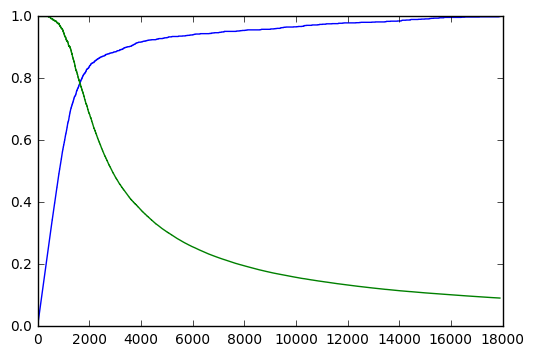

In [7]:
#train an isolation forest and score the data
iso = IsolationForest(max_samples = 8000) 
iso.fit(X[Y==0])
anomaly_scores = iso.decision_function(X)

rank_inds = np.argsort(anomaly_scores) #sort in decending order: more anomalous things have lower values 
                                       #of the decision function
Y_sorted = Y[rank_inds]

Total_P = Y.sum()
Total_N =(Y.shape[0] - Y.sum())

#work out the TP & FP rate for all possible cutoffs
TP = np.zeros(Y.shape[0])
FP = np.zeros(Y.shape[0])
TN = np.zeros(Y.shape[0])
FN = np.zeros(Y.shape[0])
for i in xrange(1,Y.shape[0]):
    TP[i] = Y_sorted[:i].sum() #number of positives recorded at this cutoff
    FP[i] = i - TP[i]          #number of candidates returned not positive
    FN[i] = Y_sorted[i:].sum() #number of positives rejected
    TN[i] = Total_N - FP[i]


recall = TP / (TP + FN)

precision = TP / (TP + FP)

plt.plot(recall)
plt.plot(precision)

Is this good enough to be useful? Also see how useful the isolation score is as a feature? 

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in divide


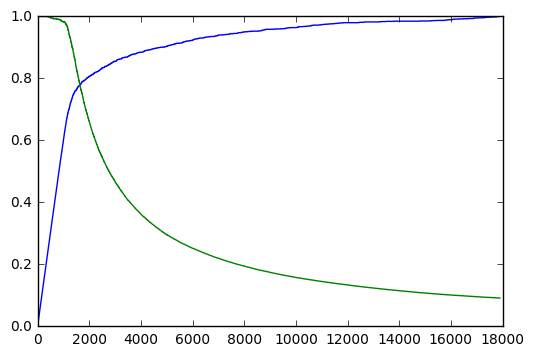

In [32]:
#compare this to the kurtosis

rank_inds = np.argsort(X[:,3])
Y_sorted = Y[rank_inds][::-1]
Total_P = Y.sum()
Total_N =(Y.shape[0] - Y.sum())

#work out the TP & FP rate for all possible cutoffs
TP = np.zeros(Y.shape[0])
FP = np.zeros(Y.shape[0])
TN = np.zeros(Y.shape[0])
FN = np.zeros(Y.shape[0])
for i in xrange(1,Y.shape[0]):
    TP[i] = Y_sorted[:i].sum() #number of positives recorded at this cutoff
    FP[i] = i - TP[i]          #number of candidates returned not positive
    FN[i] = Y_sorted[i:].sum() #number of positives rejected
    TN[i] = Total_N - FP[i]


recall = TP / (TP + FN)

precision = TP / (TP + FP)
plt.plot(recall)
plt.plot(precision)


In [44]:
%%bash
#some shell magic: create a file with the isolation score appended as a feature
./scripts/arff_to_basic_data < datasets/htru2_period+Lyon_features.arff |  sed 's/^[0-9]*\.[0-9]* //g' \
> tmp/htru2_lyon_features.dat

In [26]:
#write the isolation scores for htru2 to a file
with open('tmp/htru2_isolation_scores.dat', 'w') as f:
    for iscore in anomaly_scores:
        print >>f,iscore


In [27]:
!paste -d ' ' tmp/htru2_isolation_scores.dat tmp/htru2_lyon_features.dat > tmp/htru2_iso_score+lyon_features.dat

In [28]:
!python src/frb_features/frb_discretise.py tmp/htru2_iso_score+lyon_features.dat | ./src/MICalc++/micalc

--MI--
3 0.30311
0 0.275331
1 0.268313
4 0.238056
6 0.169795
7 0.138069
2 0.113107
5 0.104326
8 0.0324533
--JMI--
3 0.30311
6 0.328038
1 0.615692
0 0.925767
4 1.14516
7 1.36104
2 1.58142
5 1.66115
8 1.68677
--HD--
3 0.991881
4 0.944543
1 0.931066
6 0.866092
7 0.849735
2 0.815606
5 0.809377
8 0.716841
0 0.715139


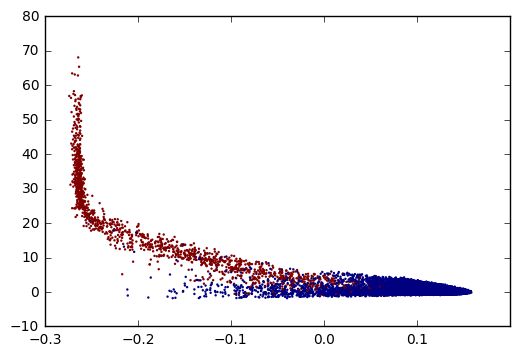

In [30]:
plt.scatter(anomaly_scores,X[:,3], c = Y, s = 3, edgecolors='none')

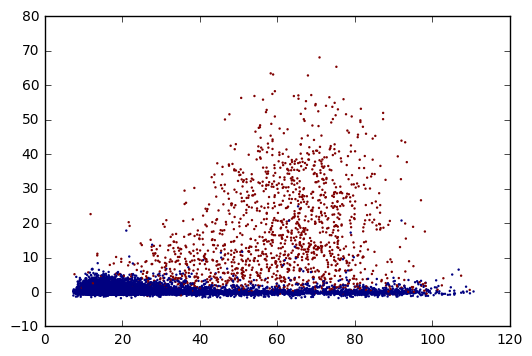

In [21]:
plt.scatter(X[:,5], X[:,3], c = Y, edgecolors = 'none', s=3)